In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv
from pathlib import Path
import warnings
from skimage.feature import hog
import tqdm

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/README.dataset.txt
/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/README.roboflow.txt
/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/valid/youtube-562_jpg.rf.1d5751c9cba98c8646575619a37b830c.jpg
/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/valid/youtube-66_jpg.rf.ff4f16706c4b13c6882c2fee78406025.jpg
/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/valid/youtube-133_jpg.rf.3f89c1656567a5edf64bfc2a9e98c17a.jpg
/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/valid/yo

In [2]:
train_annotations = pd.read_csv("/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/train/_annotations.csv")

In [3]:
train_annotations.head(20)

,filename,x,y,width,height,target
0,youtube-570_jpg.rf.f9e407730fe03cf3db1650131c0...,13.0,3.0,629.0,187.0,sugarcane
1,youtube-570_jpg.rf.f9e407730fe03cf3db1650131c0...,115.0,393.0,534.0,640.0,maize
2,youtube-570_jpg.rf.f9e407730fe03cf3db1650131c0...,0.0,172.0,368.0,402.0,maize
3,youtube-570_jpg.rf.f9e407730fe03cf3db1650131c0...,362.0,201.0,635.0,423.0,maize
4,youtube-412_jpg.rf.f9f9fd9d46adc6a8a238dad7642...,267.0,160.0,375.0,591.0,maize
5,youtube-412_jpg.rf.f9f9fd9d46adc6a8a238dad7642...,307.0,4.0,640.0,142.0,maize
6,youtube-412_jpg.rf.f9f9fd9d46adc6a8a238dad7642...,390.0,163.0,619.0,601.0,maize
7,youtube-412_jpg.rf.f9f9fd9d46adc6a8a238dad7642...,133.0,3.0,284.0,110.0,sugarcane
8,youtube-193_jpg.rf.fa14f76024d850b8e194a7d9569...,147.0,27.0,420.0,328.0,maize
9,youtube-193_jpg.rf.fa14f76024d850b8e194a7d9569...,432.0,0.0,532.0,36.0,maize


In [4]:
train_annotations.nunique()

filename    934
x           618
y           627
width       618
height      618
target        5
dtype: int64

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
categories = ['target']
for cat in categories:
    df_cat = train_annotations.groupby(cat,as_index=False).size().sort_values(ascending=False).head(10)
    df_cat.plot(kind='bar',title = cat)
    plt.show()

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [6]:
image_path = "/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/train"

In [7]:
cv.imread(image_path + "/youtube-103_jpg.rf.f64175f17100866687c9886dda5d94c1.jpg", cv.IMREAD_GRAYSCALE)

array([[ 83, 221, 211, ...,  91,  80,  88],
       [ 83, 227, 232, ...,  86,  80,  77],
       [ 88, 227, 234, ...,  83,  84,  76],
       ...,
       [ 83,  85,  85, ..., 234, 235, 237],
       [ 84,  85,  85, ..., 232, 235, 239],
       [ 84,  85,  85, ..., 229, 235, 240]], dtype=uint8)

In [8]:
all_images = []
#labels = []

def load_image(filename,path=image_path):
    img = cv.imread(image_path + "/" + filename,cv.IMREAD_GRAYSCALE) #load at gray scale
    #img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #convert to gray scale
    return img,filenames

for filenames in tqdm(list(train_annotations.filename)[:20000]):
    img,filenames = load_image(str(filenames))
    if img is not None:
        all_images.append([img,filenames])
    #labels.append(ids)
len(all_images)

 46%|████▋     | 2681/5788 [00:13<00:15, 198.47it/s][ WARN:0@58.244] global loadsave.cpp:244 findDecoder imread_('/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/train/nan'): can't open/read file: check file path/integrity
[ WARN:0@58.244] global loadsave.cpp:244 findDecoder imread_('/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/train/nan'): can't open/read file: check file path/integrity
 62%|██████▏   | 3588/5788 [00:18<00:11, 188.34it/s][ WARN:0@62.612] global loadsave.cpp:244 findDecoder imread_('/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/train/nan'): can't open/read file: check file path/integrity
[ WARN:0@62.612] global loadsave.cpp:244 findDecoder imread_('/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Mai

5748

In [13]:
def resize_image(img,filenames):
    return cv.resize(img, (80, 80),interpolation =cv.INTER_LINEAR)
    
all_images_resized = [[resize_image(x,y),y] for x,y in all_images]
len(all_images_resized)

5748

In [14]:
[train_annotations.target.value_counts().index]

[Index(['maize', 'grass', 'sugarcane', 'banana', 'coffee'], dtype='object')]

In [15]:
df_labels = pd.DataFrame(all_images_resized,columns=['image','filename'])

target = 'target'
categories = ['maize', 'grass', 'sugarcane', 'banana', 'coffee']
df_train = train_annotations[train_annotations[target].isin(categories)][['filename',target]]

df_labels = pd.merge(df_labels,df_train,how='left',on=['filename'])
df_labels = df_labels.fillna('others')
df_labels['class'] = pd.factorize(df_labels[target])[0]
print("Data Shape: ", str(df_labels.shape))
print(df_labels[target].value_counts())

Data Shape:  (39398, 4)
maize        24513
grass         9043
sugarcane     3898
banana        1229
coffee         715
Name: target, dtype: int64


In [16]:
#mapper for targets and labels
mapper = df_labels[['class',target]].drop_duplicates()

(80, 80)
Total Keypoints with nonmaxSuppression: 213


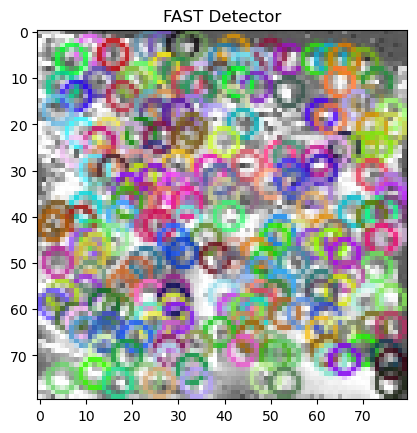

(80, 80)
Total Keypoints with nonmaxSuppression: 213


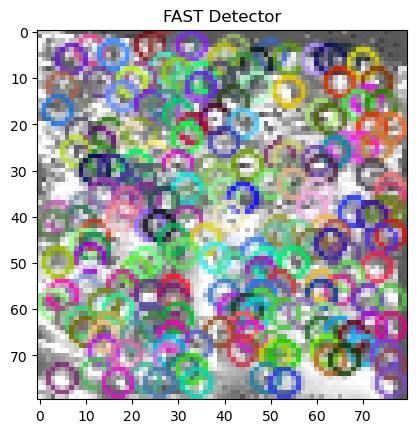

(80, 80)
Total Keypoints with nonmaxSuppression: 213


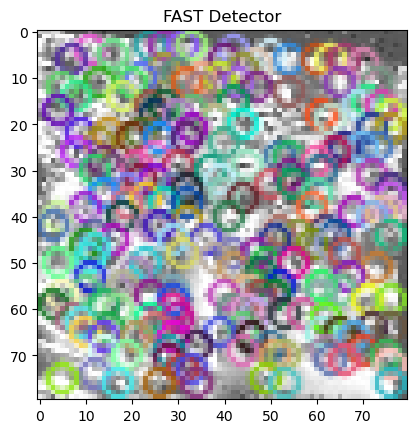

(80, 80)
Total Keypoints with nonmaxSuppression: 213


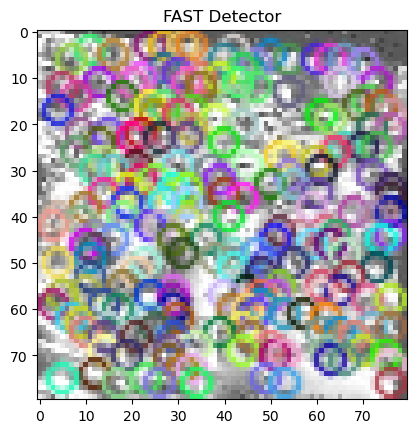

(80, 80)
Total Keypoints with nonmaxSuppression: 213


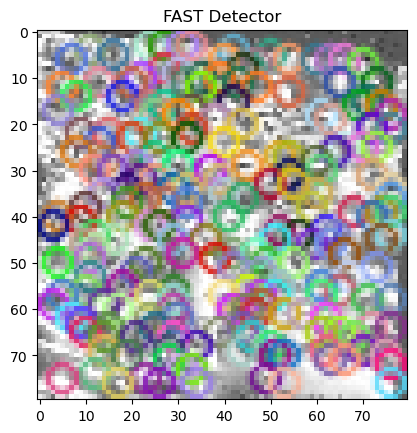

(80, 80)
Total Keypoints with nonmaxSuppression: 213


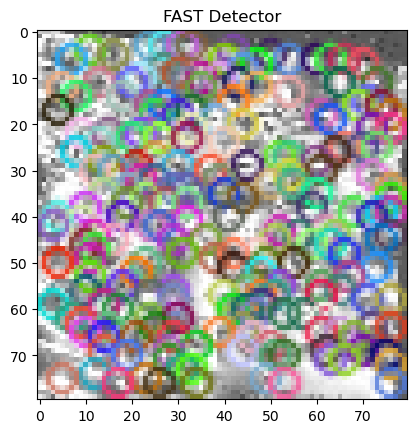

(80, 80)
Total Keypoints with nonmaxSuppression: 213


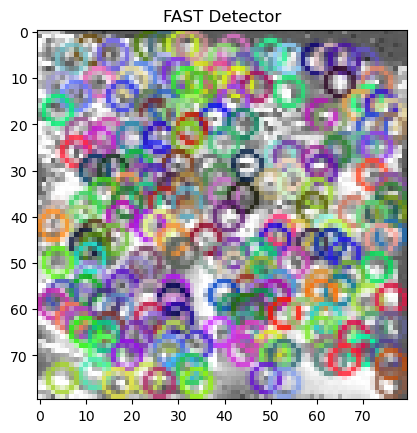

(80, 80)
Total Keypoints with nonmaxSuppression: 213


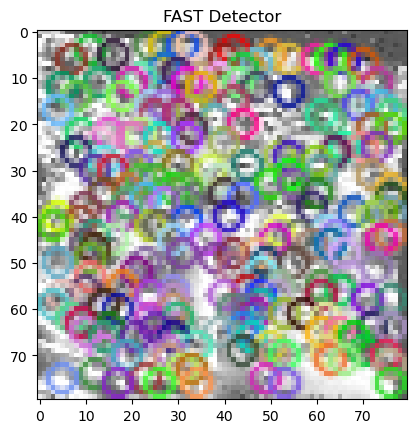

(80, 80)
Total Keypoints with nonmaxSuppression: 213


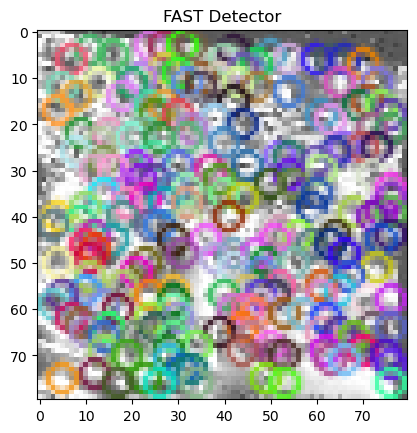

(80, 80)
Total Keypoints with nonmaxSuppression: 213


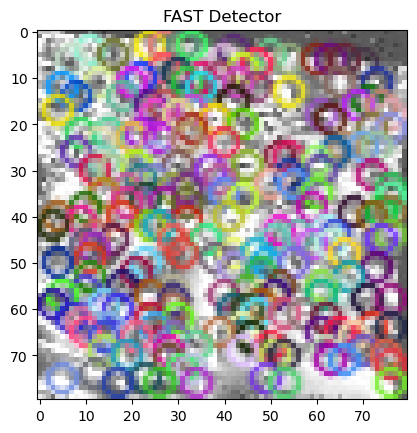

(80, 80)
Total Keypoints with nonmaxSuppression: 213


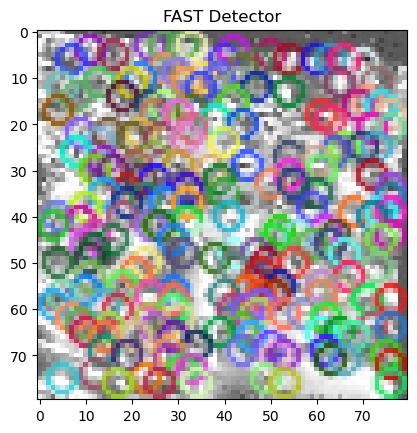

(80, 80)
Total Keypoints with nonmaxSuppression: 213


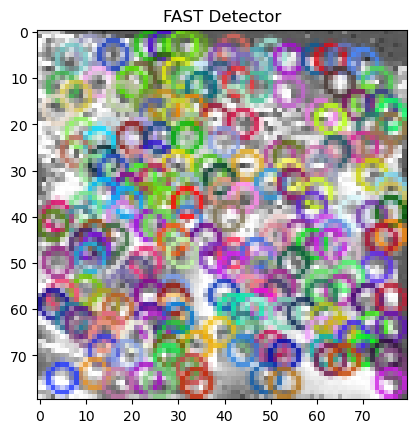

(80, 80)
Total Keypoints with nonmaxSuppression: 213


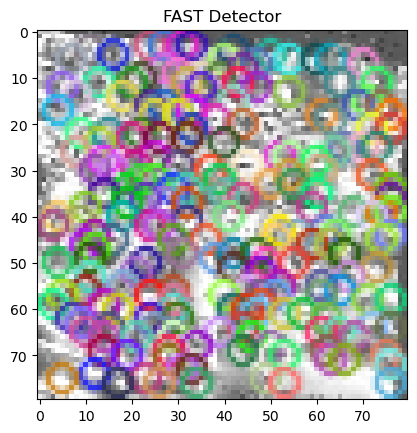

(80, 80)
Total Keypoints with nonmaxSuppression: 213


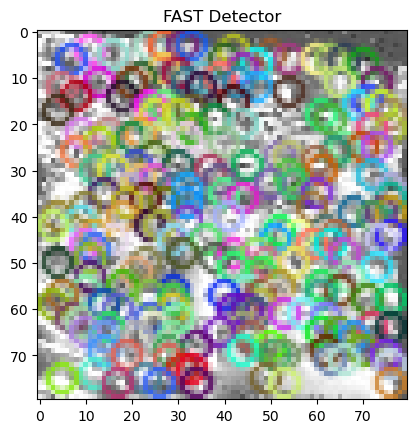

(80, 80)
Total Keypoints with nonmaxSuppression: 213


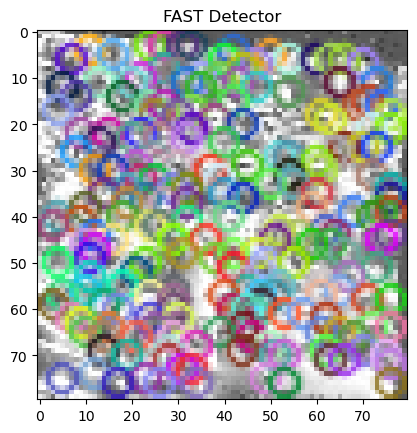

(80, 80)
Total Keypoints with nonmaxSuppression: 213


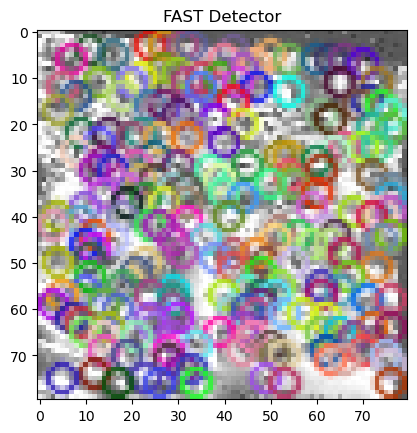

(80, 80)
Total Keypoints with nonmaxSuppression: 320


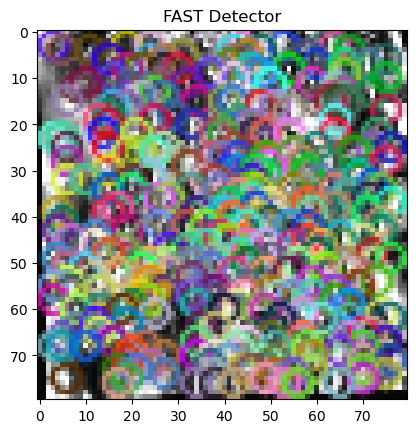

(80, 80)
Total Keypoints with nonmaxSuppression: 320


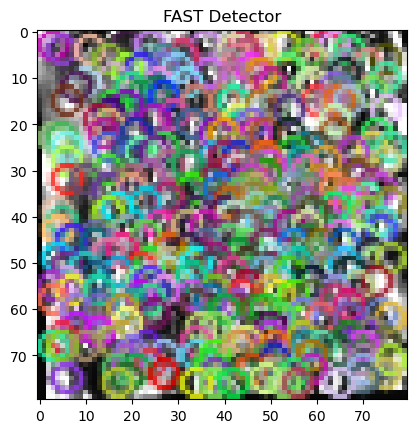

(80, 80)
Total Keypoints with nonmaxSuppression: 320


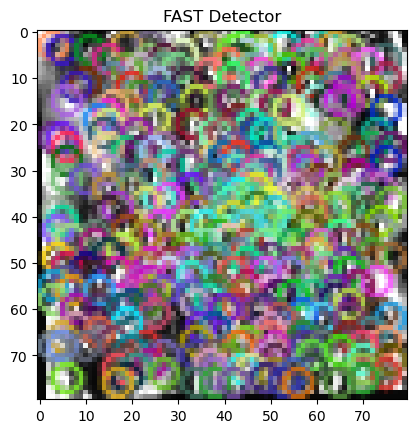

(80, 80)
Total Keypoints with nonmaxSuppression: 320


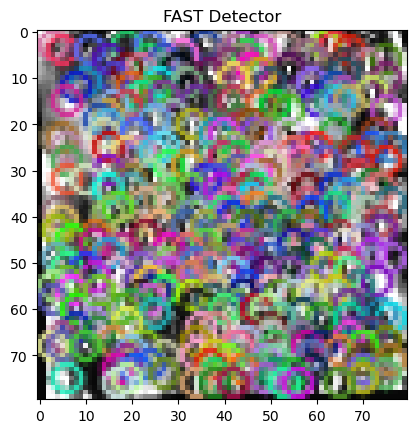

In [17]:
for image in df_labels.image[:20]:
    print(image.shape)
    plt.imshow(image)
    fast = cv.FastFeatureDetector_create(50)
    kp = fast.detect(image,None)
    img2 = cv.drawKeypoints(image, kp, None, color=(255,0,0))
    # Print all default params
    #print( "Threshold: {}".format(fast.getThreshold()) )
    #print( "neighborhood: {}".format(fast.getType()) )
    print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)))
    fast_image=cv.drawKeypoints(image,kp,image)
    plt.imshow(fast_image);plt.title('FAST Detector')
    plt.show()

In [18]:
train_images = np.stack(df_labels.image.values,axis=0)
n_samples = len(train_images)
data_images = train_images.reshape((n_samples, -1))

In [20]:
ppcr = 8
ppcc = 8
hog_images = []
hog_features = []
for image in tqdm(train_images):
    blur = cv.GaussianBlur(image,(5,5),0)
    fd,hog_image = hog(blur, orientations=8, pixels_per_cell=(ppcr,ppcc),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

hog_features = np.array(hog_features)

hog_features.shape

100%|██████████| 39398/39398 [10:55<00:00, 60.07it/s]


(39398, 2592)

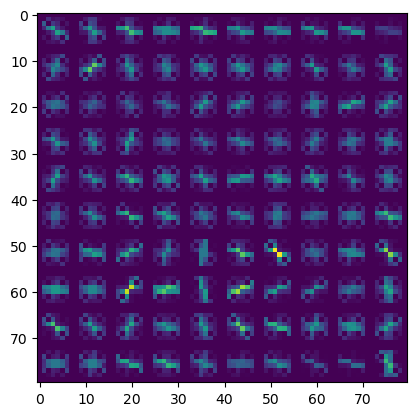

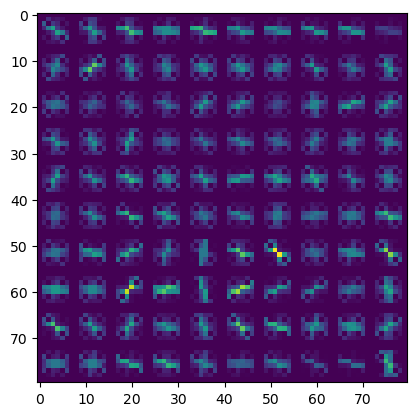

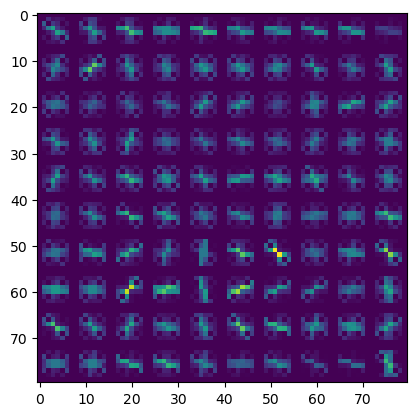

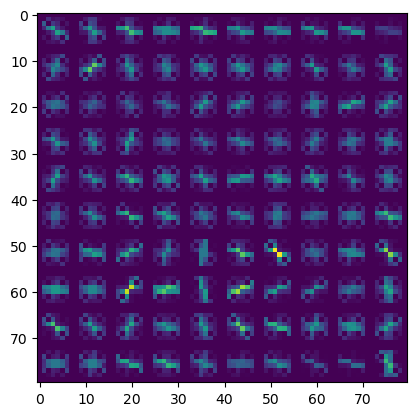

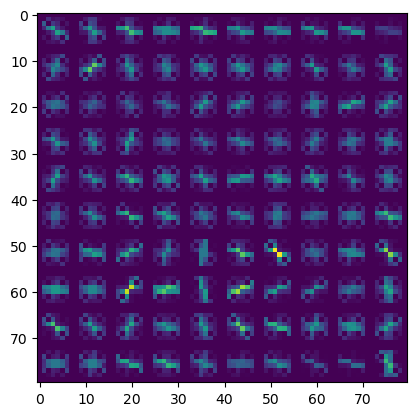

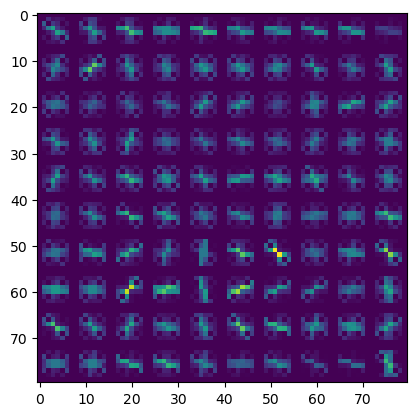

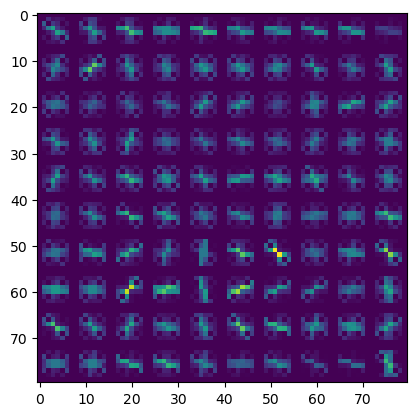

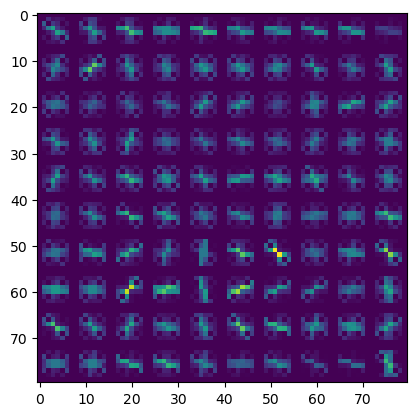

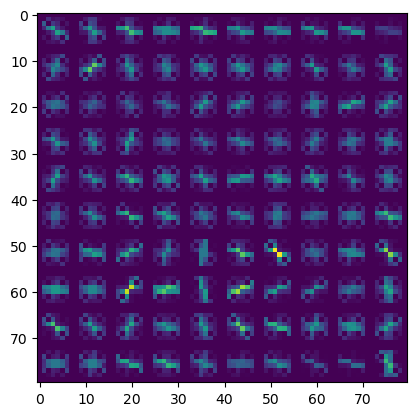

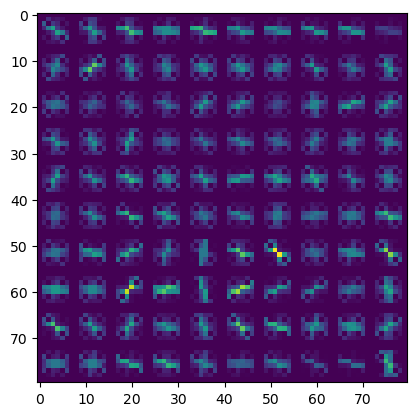

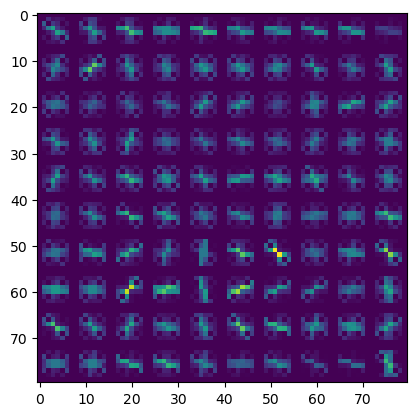

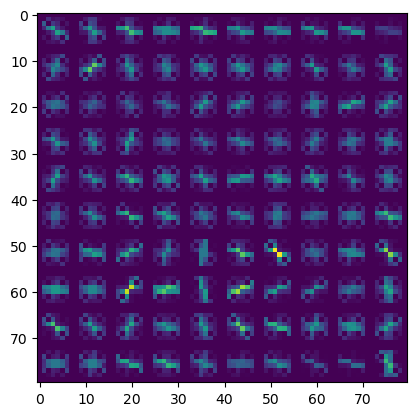

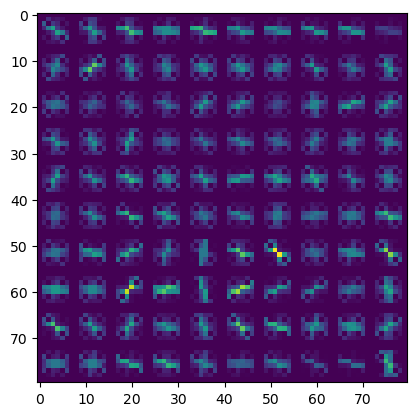

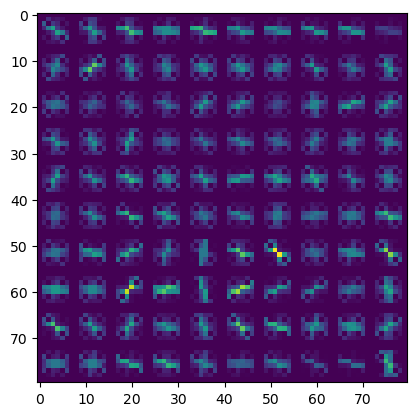

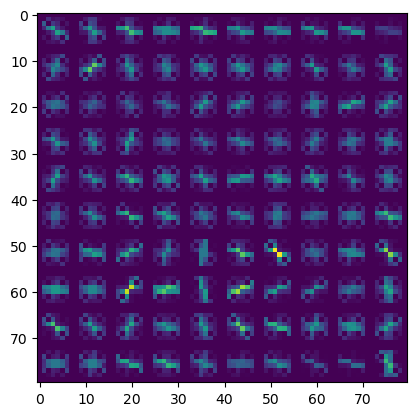

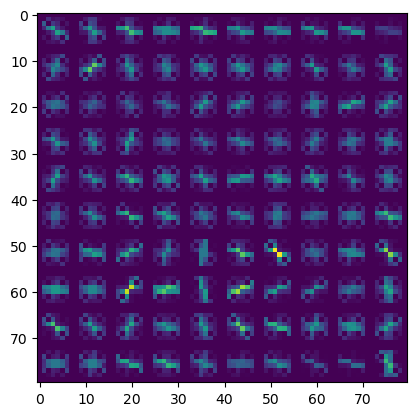

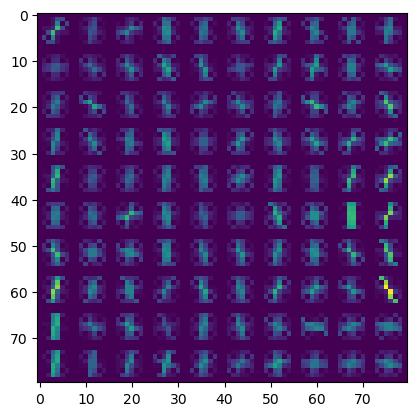

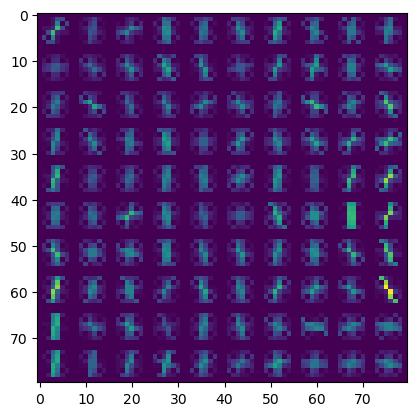

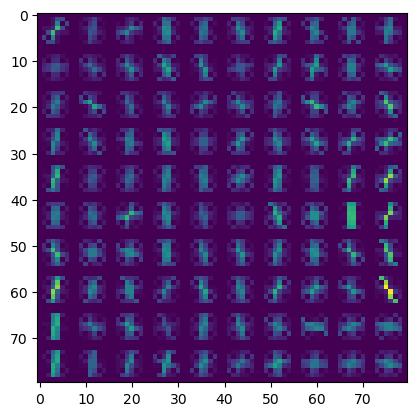

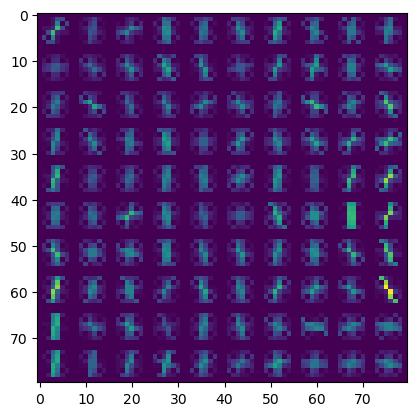

In [21]:
for img in hog_images[:20]:
    plt.imshow(img)
    plt.show()

In [22]:
edges = [cv.Canny(image,50,150,apertureSize = 3) for image in train_images]
edges = np.array(edges)
n_samples_edges = len(edges)
edge_images = edges.reshape((n_samples, -1))
edge_images.shape

(39398, 6400)

In [23]:
train_images.shape, hog_features.shape, edge_images.shape

((39398, 80, 80), (39398, 2592), (39398, 6400))

In [24]:
edge_hog = np.hstack([hog_features,edge_images])
edge_hog.shape

(39398, 8992)

In [25]:
histr = [cv.calcHist([img],[0],None,[256],[0,256]) for img in train_images]
histr = np.array(histr)
n_samples_histr = len(histr)
image_hist = histr.reshape((n_samples_histr, -1))
image_hist.shape

(39398, 256)

In [26]:
edge_hog = np.hstack([hog_features,edge_images,image_hist])
edge_hog.shape

(39398, 9248)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hog_features,df_labels['class'],test_size=0.2,stratify=df_labels['class'])
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(31518, 2592), (31518,)
Test data and target sizes: 
(7880, 2592), (7880,)


In [28]:
y_train.value_counts(),y_test.value_counts()

(1    19610
 2     7234
 0     3119
 3      983
 4      572
 Name: class, dtype: int64,
 1    4903
 2    1809
 0     779
 3     246
 4     143
 Name: class, dtype: int64)

In [29]:
from sklearn import datasets, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# # Create a classifier: a support vector classifier
# classifier = svm.SVC(gamma=0.001)
# #fit to the trainin data
# classifier.fit(X_train,y_train)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_scaled, y_train)
test_accuracy = classifier.score(scaler.transform(X_test), y_test)
print(test_accuracy)

# #FOR TUNING
# print(search_params)
# for p in tqdm(search_params):
#     #classifier = svm.SVC(gamma=p)
#     classifier = RandomForestClassifier(max_depth=8,n_estimators=600)

#     classifier.fit(X_scaled, y_train)
#     test_accuracy.append([p,classifier.score(scaler.transform(X_test), y_test)])

# df_accuracy = pd.DataFrame(test_accuracy,columns =['gamma','accuracy'])
# df_accuracy.index = df_accuracy.gamma
# df_accuracy[['accuracy']].plot()
# plt.show()

0.5450507614213198


In [31]:
mapper= mapper.reset_index(drop=True)

In [32]:
y_pred = classifier.predict(scaler.transform(X_test))

df_result = pd.DataFrame(y_test)
df_result['id'] = df_result.index
df_result = df_result.rename(columns={'class':'actual'})
df_result['predicted'] = y_pred
df_result = df_result.reset_index(drop=True)
df_result = pd.merge(df_result,mapper,left_on='predicted',right_on = 'class',how='inner')
df_result = df_result.drop(columns=['class'],axis=1)
df_result = df_result.rename(columns={'gender':'predicted_category'})

df_result = pd.merge(df_result,mapper,left_on='actual',right_on = 'class',how='inner')
df_result = df_result.drop(columns=['class'],axis=1)
df_result.shape

(7880, 5)

In [33]:
#some references for debugging
kd = df_result[df_result.actual!=df_result.predicted]
print(kd.shape)
kd.head()

(3585, 5)


,actual,id,predicted,target_x,target_y
3570,1,38575,2,grass,maize
3571,1,2116,2,grass,maize
3572,1,21847,2,grass,maize
3573,1,2157,2,grass,maize
3574,1,19759,2,grass,maize


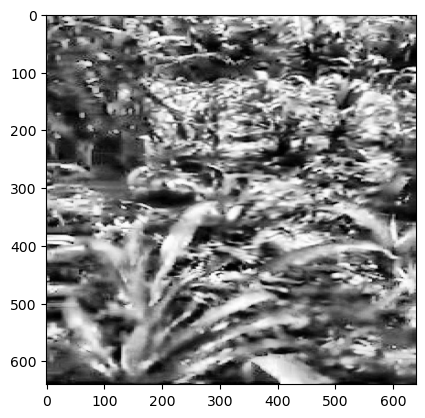

In [34]:
# image_id = styles[styles.index==2663]['id'].reset_index(drop=True)
# k = str(image_id)
# print(k)
#print(image_folder+str(image_id)+'.jpg')

#debug image with id
##it is recommended not to use the image used for training. You can make a separate test folder and check the result
img = cv.imread("/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/test/youtube-104_jpg.rf.25aea211a6c17a9c91247b2297ae787b.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img.shape
plt.imshow(img)

In [36]:
list_of_categories = categories

print("Classification Report: \n Target: %s \n Labels: %s \n Classifier: %s:\n%s\n"
      % (target,list_of_categories,classifier, metrics.classification_report(y_test, y_pred)))

df_report = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),columns = list_of_categories )
df_report.index = [list_of_categories]
df_report


Classification Report: 
 Target: target 
 Labels: ['maize', 'grass', 'sugarcane', 'banana', 'coffee'] 
 Classifier: KNeighborsClassifier(algorithm='brute', n_neighbors=3):
              precision    recall  f1-score   support

           0       0.24      0.29      0.26       779
           1       0.66      0.73      0.69      4903
           2       0.36      0.25      0.30      1809
           3       0.21      0.14      0.17       246
           4       0.10      0.06      0.08       143

    accuracy                           0.55      7880
   macro avg       0.31      0.30      0.30      7880
weighted avg       0.52      0.55      0.53      7880




,maize,grass,sugarcane,banana,coffee
maize,227,468,81,3,0
grass,501,3570,684,91,57
sugarcane,186,1106,454,35,28
banana,23,184,4,35,0
coffee,0,107,27,0,9


In [39]:
#test image with id
##it is recommended to use different test images which were not used for training
test_data_location = "/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/test"

img = cv.imread("/kaggle/input/crop-and-grass-detection-hog-and-knn/With Column Headers Crops -Maize- Cassava- Sugarcane Vs Grass-.v6i.retinanet/test/youtube-10_jpg.rf.eb50b17c3ece881336886949a45dab74.jpg",cv.IMREAD_GRAYSCALE) #load at gray scale
image = cv.resize(img, (60, 80),interpolation =cv.INTER_LINEAR)

ppcr = 8
ppcc = 8
hog_images_test = []
hog_features_test = []

blur = cv.GaussianBlur(image,(5,5),0)
fd_test,hog_img = hog(blur, orientations=8, pixels_per_cell=(ppcr,ppcc),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
hog_images_test.append(hog_img)
hog_features_test.append(fd)

hog_features_test = np.array(hog_features_test)
y_pred_user = classifier.predict(scaler.transform(hog_features_test))
#print(plt.imshow(hog_images_test))
print(y_pred_user)
print("Predicted Target: ", mapper[mapper['class']==int(y_pred_user)]['target'])

[1]
Predicted Target:  1    maize
Name: target, dtype: object


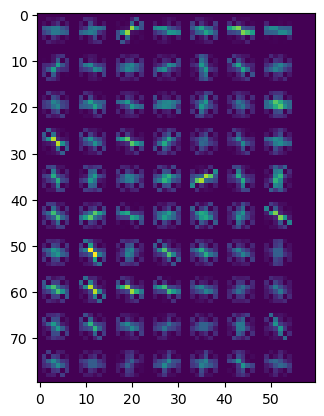

In [40]:
#test image HOG
plt.imshow(hog_img)
plt.show()

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

scaler_global = MinMaxScaler()
final_features_scaled = scaler_global.fit_transform(hog_features)
    
neighbors = NearestNeighbors(n_neighbors=20, algorithm='brute')
neighbors.fit(final_features_scaled)

distance,potential = neighbors.kneighbors(scaler_global.transform(hog_features_test))
print("Potential Neighbors Found!")
neighbors = []
for i in potential[0]:
    neighbors.append(i)

recommendation_list = list(df_labels.iloc[neighbors]['filename'])
recommendation_list

Potential Neighbors Found!


['youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a33048d2b2895b.jpg',
 'youtube-292_jpg.rf.b3aa69ba40f89bcbc2a